# Littered Road Classification

## Data Loading

In [1]:
!kaggle datasets download -d faizalkarim/cleandirty-road-classification

Dataset URL: https://www.kaggle.com/datasets/faizalkarim/cleandirty-road-classification
License(s): CC0-1.0
100%|██████████████████████████████████████| 71.6M/71.6M [00:26<00:00, 2.54MB/s]
100%|██████████████████████████████████████| 71.6M/71.6M [00:26<00:00, 2.78MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/home/bhxveshhh/DeepLearning/Littered Road Classification/cleandirty-road-classification.zip', 'r')
zip_ref.extractall('/home/bhxveshhh/DeepLearning/Littered Road Classification')
zip_ref.close()

## Data Preparation

In [3]:
# Improting Necessory Libraries

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten,GlobalAveragePooling2D, Dropout

import warnings
warnings.filterwarnings('ignore')



2025-05-10 19:58:20.288150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746887300.343011    3508 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746887300.360527    3508 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 19:58:20.499317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
images_path = '/home/bhxveshhh/DeepLearning/Littered Road Classification/Images'

labels_df = pd.read_csv('/home/bhxveshhh/DeepLearning/Littered Road Classification/metadata.csv')
print('\n\nlabels dataframe: \n', labels_df.head(), '\n\n')

class_names = ('clean', 'dirty')
num_classes = len(class_names)

img_size = (128, 128, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


labels = []
images = []
for image in labels_df.iloc:
    image_path = os.path.join(images_path, image[0])  # Use os.path.join for proper path handling
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read the image
    if img is not None:  # Check if the image was successfully read
        resized_img = cv2.resize(img, img_size[0:2])  # Resize the image
        images.append(np.asarray(resized_img[:, :, ::-1]))  # Convert BGR to RGB and append
    else:
        print(f"Warning: Unable to read image {image_path}")
    label = np.zeros(num_classes)
    label[image[1]] = 1
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')

In [7]:
# Creating Dataframe

def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

In [8]:
# Split dataframe to train, valid, and test

def split_data(data_dir):

    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [10]:
# Define the function to create a dataframe
def define_df(filepaths, labels):
	return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Define the data directory
data_dir = images_path

# Spliting data into train, test and validation dataframe
train_df, valid_df, test_df = split_data(data_dir)

In [11]:
## Data Augmentation

def scalar(img):
        return img

def create_gens(train_df, valid_df, test_df, batch_size):

    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)


    ts_length = len(test_df)
    test_batch_size = max(
        sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

    test_steps = ts_length // test_batch_size

    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        horizontal_flip=True,
        rotation_range=20,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
    )


    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Train Generator
    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # Validation Generator
    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # Test Generator
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=False,
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)
     


Found 189 validated image filenames belonging to 1 classes.
Found 24 validated image filenames belonging to 1 classes.
Found 24 validated image filenames belonging to 1 classes.


## Data Visualization

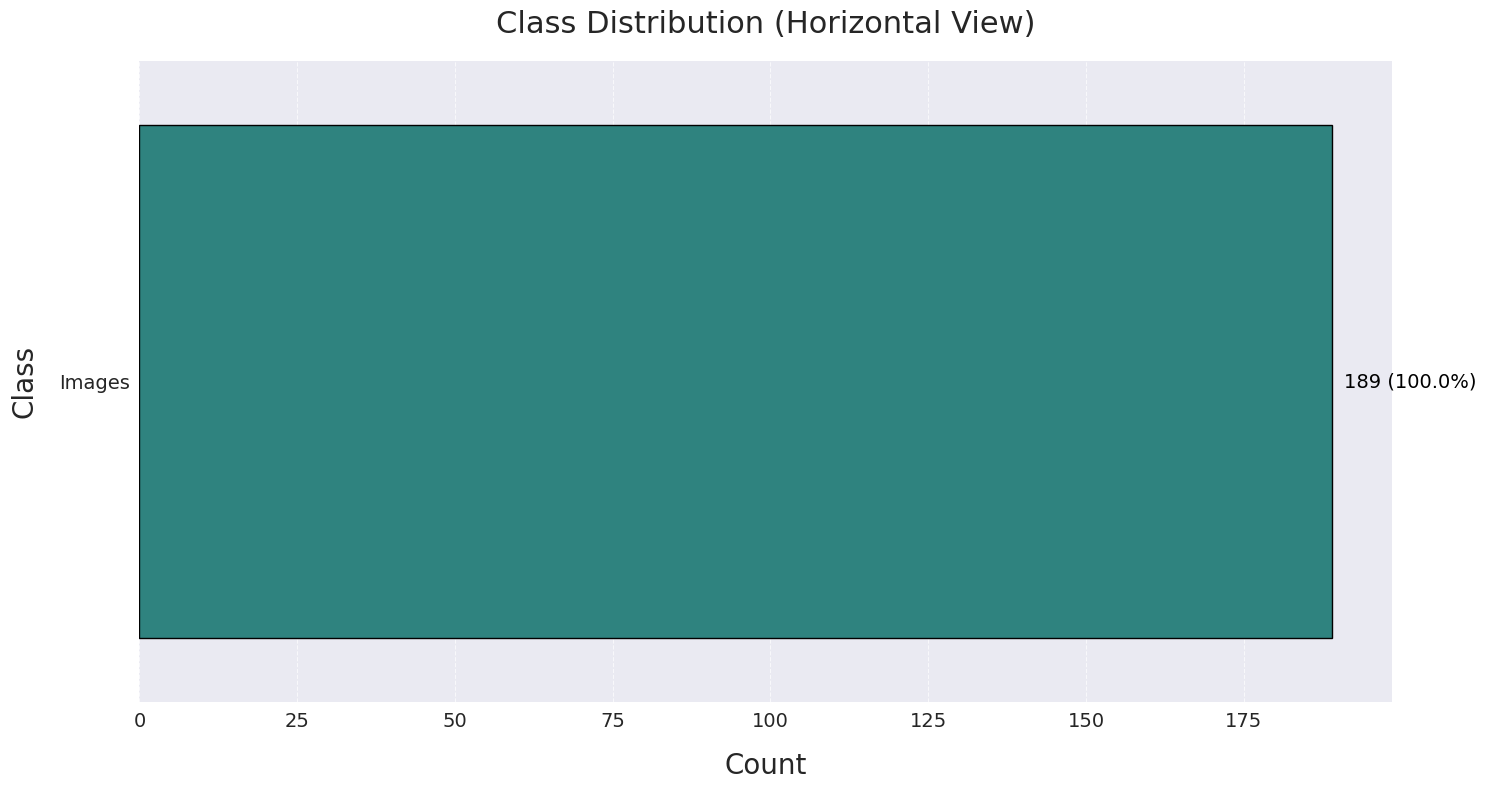

In [12]:
# Plot to analyze total count of different images present in the dataset

sns.set_style("darkgrid")

class_counts = train_df['labels'].value_counts()
plt.figure(figsize=(15, 8))
ax = sns.barplot(
    y=class_counts.index,
    x=class_counts.values,
    palette='viridis',
    edgecolor='black',
    orient='h'
)

ax.set_ylabel("Class", fontsize=20, labelpad=15)
ax.set_xlabel("Count", fontsize=20, labelpad=15)
plt.title('Class Distribution (Horizontal View)', fontsize=22, pad=20)

for i, value in enumerate(class_counts.values):
    percentage = f"{(value / class_counts.sum() * 100):.1f}%"
    ax.text(value + max(class_counts.values) * 0.01, i, f"{value} ({percentage})",
            va='center', fontsize=14, color='black')

plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

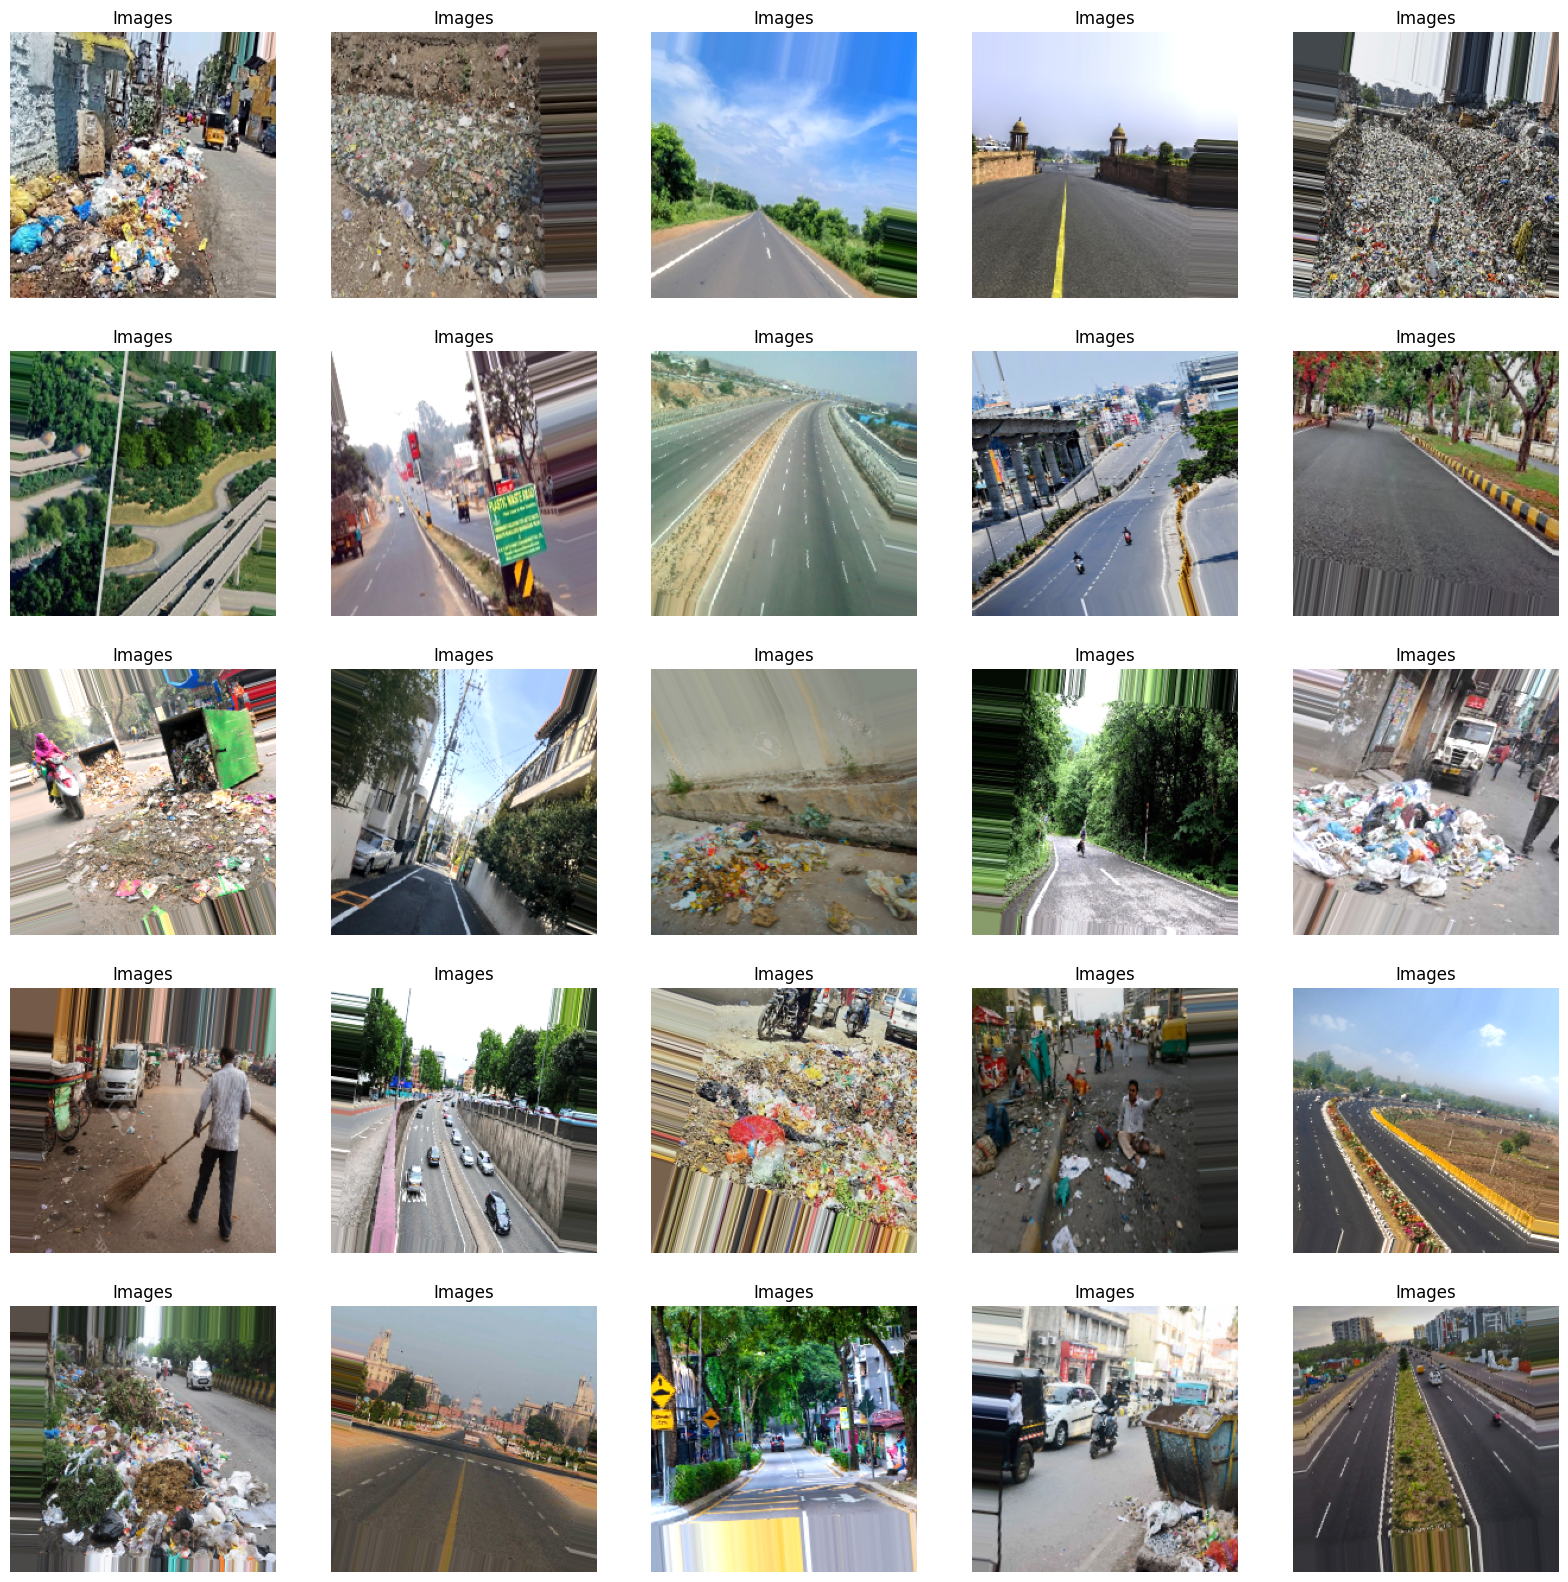

In [13]:

# Plotting sample images from the dataset

def show_images(gen):

    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'black', fontsize= 12)
        plt.axis('off')
    plt.show()
     

show_images(train_gen)


## Model Building

In [14]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False

I0000 00:00:1746887486.835922    3508 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4148 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [15]:
model = Sequential([

    base_model,
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')

])

In [16]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,199,664 (42.72 MB)

 Trainable params: 413,057 (1.58 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [22]:
history = model.fit(
    x=train_gen,
    epochs=5,
    verbose=1,
    validation_data=valid_gen,
)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


## Model Evaluation

In [23]:
history_df = pd.DataFrame(history.history)

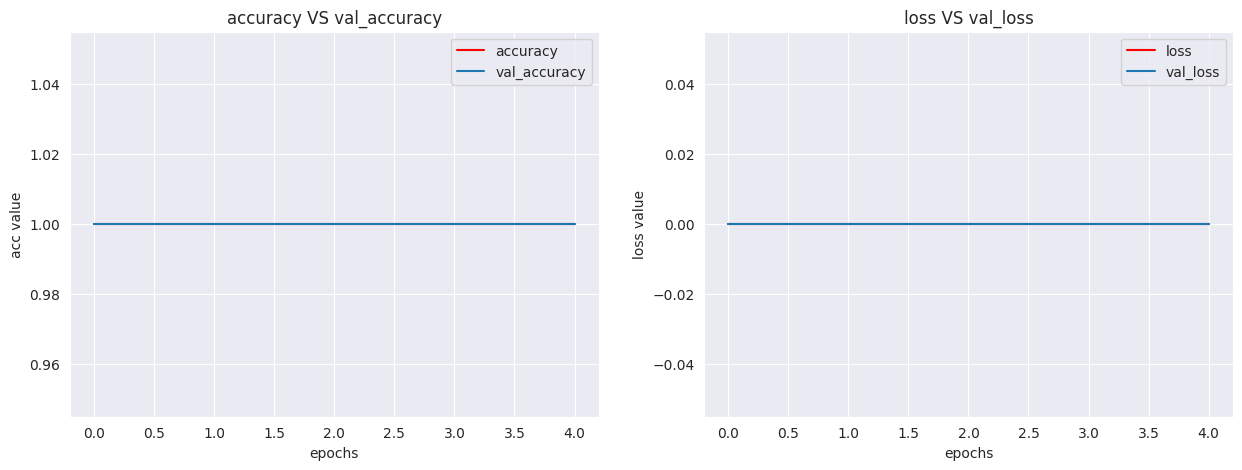

In [24]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()